# Merixstudio tweet sentiment analysis

This is a little side project I did to investigate Merixstudio tweets.

The project uses a couple of things:

- `tweepy` for Twitter communication and downloading tweets,
- `nltk` for English stopwords,
- `gcld3` to detect tweet language,
- `textblob` to calculate sentiment,
- `pandas` to make data wrangling easier,
- `wordcloud` to display nice... well... word clouds,
- `matplotlib` and `seaborn` to display graphs.

## Initial notebook settings

We will start with importing necessary Python packages.

In [1]:
# Downloading tweets
import tweepy

# Data wrangling
from datetime import datetime
import re
import gcld3
import nltk
from nltk.corpus import stopwords
import pandas as pd
from textblob import TextBlob

# Data analysis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download nltk data
nltk.download('stopwords')

# Setup Seaborn
sns.set()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukzmu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Those are the variables used to setup the project.


- `API_KEY`, `API_KEY_SECRET`, `ACCESS_TOKEN` and `ACCESS_TOKEN_SECRET` are Twitter related.
   - You can get those from the [Twitter Developer account](https://developer.twitter.com/en/apply-for-access),
- `DATA_FILE` is used to tell `pandas` where to save the tweets in the form of a `csv` file,
- `USER_NAME` is the twitter handle of the user, whose tweets will be downloaded,
- `DOWNLOAD_TWEETS` is there to stop the script from downloading tweets every time you run the Notebook. It is quite easy to reach the API rate limits.

In [2]:
# Notebook variables
API_KEY = ""
API_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
DATA_FILE = "merixstudio.csv"
USER_NAME = "merix_studio"
DOWNLOAD_TWEETS = False

## Gathering Merixstudio tweets

We will start by creating a `tweepy` API client and downloading the timeline of `@merix_studio` user. Then, we will save the feed into a separate file.

In [3]:
# To load user tweets, we are using the DOWNLOAD_TWEETS flag,
# not to download the data every time, as the API has rate limits.
if DOWNLOAD_TWEETS:
    tweepy_auth = tweepy.OAuthHandler(API_KEY, API_KEY_SECRET)
    tweepy_auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    tweepy_api = tweepy.API(tweepy_auth)
    tweets = tweepy.Cursor(
        tweepy_api.user_timeline,
        screen_name="@merix_studio",
        tweet_mode="extended"
    ).items()

    json_data = [tweet._json for tweet in tweets]
    df = pd.json_normalize(json_data)
    df.to_csv(DATA_FILE)

Let's display latest tweets!

In [4]:
df = pd.read_csv(
    DATA_FILE,
    usecols=["created_at", "full_text"],
    parse_dates=["created_at"],
)
df.head(10)

,created_at,full_text
0,2021-11-02 15:28:56+00:00,"Pitching all the time - a few stages, way more..."
1,2021-11-02 14:02:08+00:00,Revolution or evolution? Which one is better f...
2,2021-11-02 08:18:11+00:00,RT @WebSummit: We're less than an hour away fr...
3,2021-11-01 19:12:06+00:00,RT @WebSummit: 'Web Summit is about meeting ol...
4,2021-11-01 19:11:03+00:00,RT @CamaraLisboa: Está oficialmente aberta a #...
5,2021-11-01 18:42:37+00:00,@WebSummit Here it is happening! ;) #WebSummit...
6,2021-11-01 18:29:09+00:00,How are you doing @WebSummit? We're here - @ku...
7,2021-10-29 09:43:45+00:00,Jak się mają filmowe sceny hakowania do życia?...
8,2021-10-29 06:41:02+00:00,@RitaMartinsUK Spot and meet us! ;)
9,2021-10-29 06:31:56+00:00,@minnatech @WebSummit @JoakimSjoblom See you g...


We have our dataset now... but how big is it?

In [5]:
print(f"Total number of tweets: {df.shape[0]}")

Total number of tweets: 2376


## Cleaning the data

As you might already know, you can't really start doing anything serious in Data Science with dirty data. We will clean up the tweets by:

- removing hashtags and mentions,
- removing links,
- removing punctuation,
- removing stopwords *(words in any language which don't add much meaning to a sentence)*,
- dropping tweets that are just too short for proper analysis.

Below you can see the `clean_tweet` function.

In [6]:
def clean_tweet(text: str) -> str:
    temp = text.lower()

    # Remove hashtags and mentions
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)

    # Remove links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)

    # Remove punctuation
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)

    # Tokenize tweet
    temp = temp.split()

    # Remove stopwords
    temp = [word for word in temp if word not in stopwords.words()]

    return " ".join(temp)

And used in action:

In [7]:
df["clean_text"] = df["full_text"].apply(clean_tweet)
df.head(10)

,created_at,full_text,clean_text
0,2021-11-02 15:28:56+00:00,"Pitching all the time - a few stages, way more...",pitching time stages way people listening awe
1,2021-11-02 14:02:08+00:00,Revolution or evolution? Which one is better f...,revolution evolution better enterprise product...
2,2021-11-02 08:18:11+00:00,RT @WebSummit: We're less than an hour away fr...,rt less hour away action day year 1 250 startu...
3,2021-11-01 19:12:06+00:00,RT @WebSummit: 'Web Summit is about meeting ol...,rt web summit meeting old friends making new c...
4,2021-11-01 19:11:03+00:00,RT @CamaraLisboa: Está oficialmente aberta a #...,rt oficialmente aberta
5,2021-11-01 18:42:37+00:00,@WebSummit Here it is happening! ;) #WebSummit...,happening
6,2021-11-01 18:29:09+00:00,How are you doing @WebSummit? We're here - @ku...,giovanni spychalski meet greet
7,2021-10-29 09:43:45+00:00,Jak się mają filmowe sceny hakowania do życia?...,jak maj filmowe sceny hakowania ycia w dzisiej...
8,2021-10-29 06:41:02+00:00,@RitaMartinsUK Spot and meet us! ;),spot meet us
9,2021-10-29 06:31:56+00:00,@minnatech @WebSummit @JoakimSjoblom See you g...,see guys


Remember to drop short tweets:

In [8]:
df = df[df["clean_text"].str.len() >= 10]

## Language detection

We will use the `gcld3.NNetLanguageIdentified` to discover the language of the tweet. The *Compact Language Detector v3* by Google is a fast neural network model for language identification. This will greately speed up the process, as we don't want to build something like that from scratch.

In [9]:
detector = gcld3.NNetLanguageIdentifier(
    min_num_bytes=10,
    max_num_bytes=1000,
)

def detect_language(text: str) -> str:
    return detector.FindLanguage(text=text).language

In [10]:
# Get tweet languages
df["language"] = df["full_text"].apply(detect_language)

# Did this work?
df.head(10)

,created_at,full_text,clean_text,language
0,2021-11-02 15:28:56+00:00,"Pitching all the time - a few stages, way more...",pitching time stages way people listening awe,en
1,2021-11-02 14:02:08+00:00,Revolution or evolution? Which one is better f...,revolution evolution better enterprise product...,en
2,2021-11-02 08:18:11+00:00,RT @WebSummit: We're less than an hour away fr...,rt less hour away action day year 1 250 startu...,en
3,2021-11-01 19:12:06+00:00,RT @WebSummit: 'Web Summit is about meeting ol...,rt web summit meeting old friends making new c...,en
4,2021-11-01 19:11:03+00:00,RT @CamaraLisboa: Está oficialmente aberta a #...,rt oficialmente aberta,hu
6,2021-11-01 18:29:09+00:00,How are you doing @WebSummit? We're here - @ku...,giovanni spychalski meet greet,en
7,2021-10-29 09:43:45+00:00,Jak się mają filmowe sceny hakowania do życia?...,jak maj filmowe sceny hakowania ycia w dzisiej...,pl
8,2021-10-29 06:41:02+00:00,@RitaMartinsUK Spot and meet us! ;),spot meet us,lb
10,2021-10-28 12:46:57+00:00,Next week we're going to #Lisbon to visit the ...,next week going visit great event looking forw...,en
11,2021-10-28 10:52:09+00:00,@AlinaWhoCodes @WebSummit We are going this ye...,going year read article,en


As you can see, not everything is correct, but that doesn't matter! It is really hard to get the language correct on short sentences - most importantly, we got English where we need it.

## Sentiment analysis

Last but not least, we will use sentiment analysis provided by `TextBlob` - a library for processing textual data, that handles common NLP tasks.

- Polarity is **higher than 0** means that the tweet is **positive**,
- Polarity **lower than 0** means that the tweet is **negative**,
- Polarity **of 0** is **neutral**.

In [11]:
def get_polarity(text: str) -> float:
    return TextBlob(text).sentiment.polarity

In [12]:
def get_subjectivity(text: str) -> float:
    return TextBlob(text).sentiment.subjectivity

In [13]:
def get_sentiment(polarity: float) -> str:
    if polarity > 0:
        return "Positive"
    if polarity < 0:
        return "Negative"
    return "Neutral"

In [14]:
df["polarity"] = df["clean_text"].apply(get_polarity)
df["subjectivity"] = df["clean_text"].apply(get_subjectivity)
df["sentiment"] = df["polarity"].apply(get_sentiment)
df.head(10)

,created_at,full_text,clean_text,language,polarity,subjectivity,sentiment
0,2021-11-02 15:28:56+00:00,"Pitching all the time - a few stages, way more...",pitching time stages way people listening awe,en,0.000000,0.000000,Neutral
1,2021-11-02 14:02:08+00:00,Revolution or evolution? Which one is better f...,revolution evolution better enterprise product...,en,0.500000,0.500000,Positive
2,2021-11-02 08:18:11+00:00,RT @WebSummit: We're less than an hour away fr...,rt less hour away action day year 1 250 startu...,en,-0.033333,0.083333,Negative
3,2021-11-01 19:12:06+00:00,RT @WebSummit: 'Web Summit is about meeting ol...,rt web summit meeting old friends making new c...,en,0.118182,0.327273,Positive
4,2021-11-01 19:11:03+00:00,RT @CamaraLisboa: Está oficialmente aberta a #...,rt oficialmente aberta,hu,0.000000,0.000000,Neutral
6,2021-11-01 18:29:09+00:00,How are you doing @WebSummit? We're here - @ku...,giovanni spychalski meet greet,en,0.000000,0.000000,Neutral
7,2021-10-29 09:43:45+00:00,Jak się mają filmowe sceny hakowania do życia?...,jak maj filmowe sceny hakowania ycia w dzisiej...,pl,0.000000,0.000000,Neutral
8,2021-10-29 06:41:02+00:00,@RitaMartinsUK Spot and meet us! ;),spot meet us,lb,0.000000,0.000000,Neutral
10,2021-10-28 12:46:57+00:00,Next week we're going to #Lisbon to visit the ...,next week going visit great event looking forw...,en,0.268182,0.414773,Positive
11,2021-10-28 10:52:09+00:00,@AlinaWhoCodes @WebSummit We are going this ye...,going year read article,en,0.000000,0.000000,Neutral


## Data Analysis of the results

Let's start by looking, what is the sentiment of `@merix_studio` tweets!

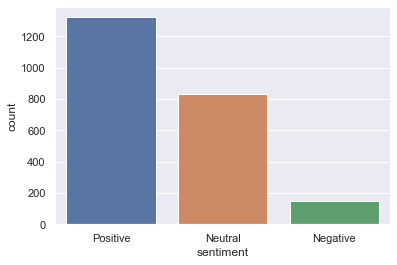

In [15]:
sns.countplot(
    x="sentiment",
    data=df,
    order=df["sentiment"].value_counts().index,
)
plt.show()

Great news! A vast majority of `@merix_studio` tweets are **Positive** or **Neutral** 🧡. Let's see some examples!

**Positive examples:**

In [16]:
for text in df[df["sentiment"] == "Positive"].sample(5, random_state=42)["full_text"].values:
    print(f"- {text}")

- New technologies rule the world! Check out our new post adn find out how to use new technologies in marketing: https://t.co/nE01ICL52n
- @claush03g @AWWWARDS Hi! Thanks for download our Ebook! If you have interests in more information about typography in web and multi-device design - follow us on FB &amp; Instagram! https://t.co/GHk8LeyoJZ
- #NextJS can make your #JavaScript coding so much easier😎! Check some of the useful features it offers and how they can simplify your work in the second part of our Next.js guide📕!  
https://t.co/ELHttQNStz
- @baxetheo Hi! Thanks for following us :) https://t.co/LUKDLtr11f
- When should you use Django-based polymorphic models in your app creation projects? Check out our pro tips for #Python developers to find out how to create an app with the use of polymorphism in #Django💡Let us know which of the tips you found most useful! https://t.co/XE1NxH4f5f https://t.co/BTA7AJneOw


**Neutral examples:**

In [17]:
for text in df[df["sentiment"] == "Neutral"].sample(5, random_state=42)["full_text"].values:
    print(f"- {text}")

- This is why you need to test edge use cases in your designs! http://t.co/88s3IeQPTa
- Want to learn about #ContentMarketing? Read the newest article on our blog, where Anita will tell you all about it https://t.co/1u083UJIST
- Get the Typography Guide created by our #GraphicDesigner: https://t.co/dAdpbIaAjP
- And the Oscar Goes To... #AwwwardsBCN http://t.co/zjXkNT1tcP
- Check out our blog - you have a chance to meet Wiktor, the member of our #Python Developers team. He is Internet #security expert and... beer brewer! 🍻 That’s quite a combination!
#MeetMerix and Wiktor on the lates blog post 👇👇👇
https://t.co/JdpmlAKj40


Let's see whether the **Negative** examples are truly negative!

In [18]:
for text in df[df["sentiment"] == "Negative"].sample(5, random_state=42)["full_text"].values:
    print(f"- {text}")

- "Native #MobileApps are... walking dead. Mobile Web is coming" - #MTC2017 starting tomorrow! See you in #Krakow 😉 #mobile #trends https://t.co/yLAHGcUZp8
- It’s obvious that the upcoming #Christmas will be different than usual. But let’s focus on the positives. 🎄 Maybe it’s an opportunity for spending holidays like we always wanted but somehow there was no opportunity for that. So guys - Merry Christmas! 🎅 https://t.co/ZbzNMV9VJR
- Guys, Skytte (our new #html5 #canvas shooting game) need your votes too!

Please vote here:... http://t.co/iEnu1P3B7b
- We're back after the power cut and working hard now! 🤓
- Finished the secret project for @beyondpl! Raise the curtain: it's one of the most personal approaches to openings. https://t.co/cj4zdOMcnq


I think I understand where this comes from! Some of those aren't really negative, but use words that are generally found in negative sentences: `dead`, `different`, `no`, `shooting`, and more!

How about we look at the best tweet in town?

In [19]:
max_polarity = df.iloc[df["polarity"].idxmax()]["full_text"]
print(f"Best tweet: {max_polarity}")

Best tweet: @BabitaTV @IntHealthAI @djSLEEPER Good to see you all on stage ;)


We could also preview how the sentiment changed over time:

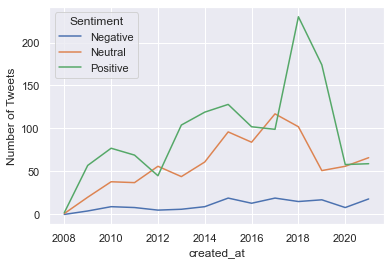

In [20]:
per_year = df.groupby(df["created_at"].dt.year)["sentiment"].value_counts().unstack(fill_value=0)
per_year = per_year.reset_index().melt(
    "created_at",
    var_name="Sentiment",
    value_name="Number of Tweets"
)
sns.lineplot(
    x="created_at",
    y="Number of Tweets",
    hue="Sentiment",
    data=per_year,
)
plt.show()

A simple Word Cloud of positive `@merix_studio` tweets:

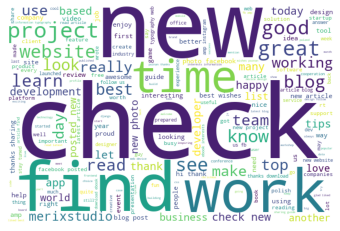

In [21]:
positive_df = df[df["sentiment"] == "Positive"]
words = " ".join([tweet for tweet in positive_df["clean_text"]])
word_cloud = WordCloud(
    width=600,
    height=400,
    background_color="white",
    random_state=42,
).generate(words)

plt.imshow(word_cloud)
plt.axis("off")
plt.show()

And the same for negative tweets 🥲:

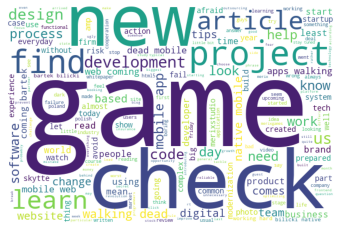

In [22]:
negative_df = df[df["sentiment"] == "Negative"]
words = " ".join([tweet for tweet in negative_df["clean_text"]])
word_cloud = WordCloud(
    width=600,
    height=400,
    background_color="white",
    random_state=42,
).generate(words)

plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Last but not least, let's compare the subjectivity to polarity. Maybe we can get some interesting insights there?

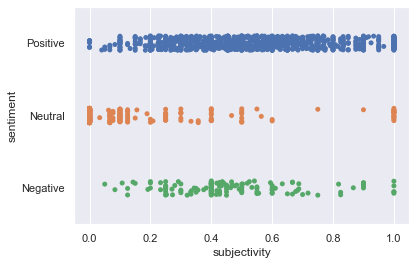

In [23]:
sns.stripplot(
    y="sentiment",
    x="subjectivity",
    data=df,
    order=df["sentiment"].value_counts().index,
)
plt.show()

We can see that most Positive and Negative tweets move higher into the subjectivity value. Neutral posts are usually objective.

And that would be all Folks! 🐰